In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np

from utils import seed_everything, Timer

In [2]:
# LeNet architecture
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
seed_everything(0xbebebe)

In [4]:
# CIFAR-10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# model
net = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
# Training
for epoch in range(10):  #
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")

print("Finished Training")

Epoch 1, Loss: 2.2289353077064087
Epoch 2, Loss: 1.8086552868413803
Epoch 3, Loss: 1.5921526676248712
Epoch 4, Loss: 1.4884830719369757
Epoch 5, Loss: 1.415162680551524
Epoch 6, Loss: 1.3572590658274453
Epoch 7, Loss: 1.2969741923424898
Epoch 8, Loss: 1.2502720736329207
Epoch 9, Loss: 1.2076691155086088
Epoch 10, Loss: 1.1745870870245083
Finished Training


Inference | Elapsed time : 2.14
Accuracy: 0.5832
Precision: 0.5839848620911217
Recall: 0.5832
F1-Score: 0.5810769878070202


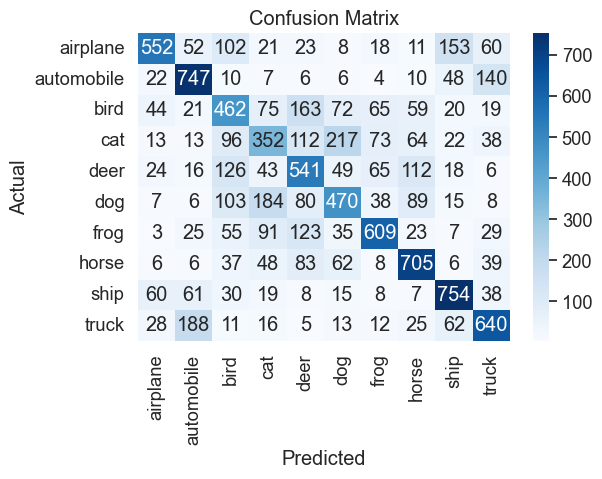

In [7]:
# Testing
def evaluate_cifar(net):
    net.eval()
    all_labels = []
    all_predictions = []

    with Timer('inference', True) as timer:
        with torch.inference_mode():
            for data in testloader:  #
                inputs, labels = data
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                all_labels.extend(labels.tolist())
                all_predictions.extend(predicted.tolist())

    # Metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Confusion matrix
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=testset.classes, yticklabels=testset.classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_cifar(net)

In [8]:
torch.save(net, 'lenet.pt')

In [9]:
print(f'LeNet size is {os.path.getsize("lenet.pt") / 2 ** 10:.1f} Kb')

LeNet size is 246.9 Kb


# Clustering

Кластеризацию будем использовать для сжатия размера модели на диске при сохранении.

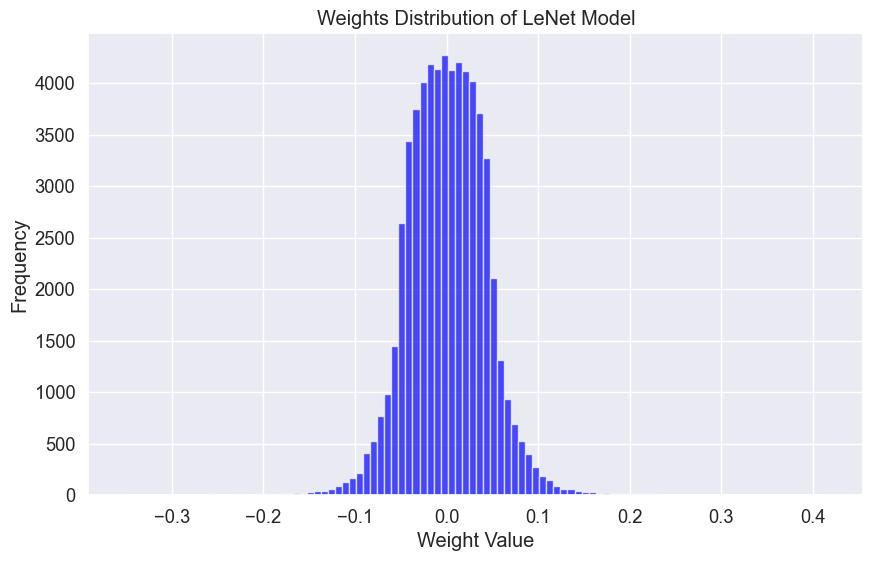

In [10]:
all_weights = torch.cat([w.flatten() for w in net.parameters()])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(all_weights.cpu().detach().numpy(), bins=100, color='blue', alpha=0.7)
plt.title('Weights Distribution of LeNet Model')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

/Users/imoshkov/prog/.base/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/imoshkov/prog/.base/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


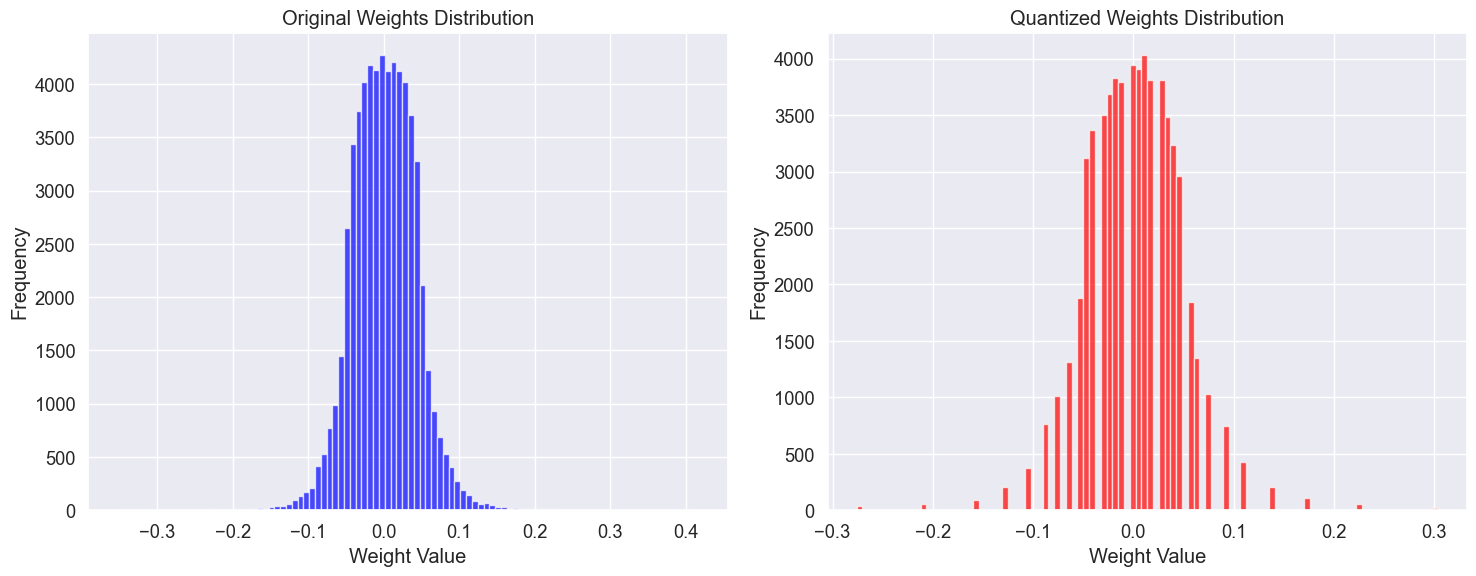

In [11]:
# Number of clusters
k = 32

# Reshape weights for KMeans
weights_np = all_weights.cpu().detach().numpy().reshape(-1, 1)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(weights_np)

# Quantize the weights to the nearest centroid
quantized_weights = kmeans.cluster_centers_[kmeans.predict(weights_np)].flatten()

# Plot original and quantized weight distributions
plt.figure(figsize=(15, 6))

# Original weights
plt.subplot(1, 2, 1)
plt.hist(weights_np, bins=100, color='blue', alpha=0.7)
plt.title('Original Weights Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True)

# Quantized weights
plt.subplot(1, 2, 2)
plt.hist(quantized_weights, bins=100, color='red', alpha=0.7)
plt.title('Quantized Weights Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


In [12]:
class CompressibleLeNet(LeNet):
    def __init__(self, clustering):
        super(CompressibleLeNet, self).__init__()
        self.centroids = None
        self.clustering = clustering
        
    def save_compressed(self, path, **clustering_params):
        all_weights = torch.cat([w.flatten() for w in self.parameters()])
        weights_np = all_weights.cpu().detach().numpy()
        
        self.clustering = self.clustering(**clustering_params).fit(weights_np.reshape(-1, 1))
        
        self.apply(self._map_weights_to_idx)
        
        compressed_dict = {
            'centroids': self.clustering.cluster_centers_.flatten(),
            'quantized_indices': self.state_dict()
        }
        torch.save(compressed_dict, path)
    
    def load_compressed(self, path):
        compressed_dict = torch.load(path)
        centroids = compressed_dict['centroids']
        self.load_state_dict(compressed_dict['quantized_indices'])
        self.apply(lambda module: self._unmap_weights_to_idx(module, centroids))
        
    def _map_weights_to_idx(self, module):
        if hasattr(module, 'weight') and module.weight is not None:
            weights_np = module.weight.data.cpu().numpy().reshape(-1, 1)
            centroids_np = self.clustering.predict(weights_np).flatten()
            module.weight.data = torch.Tensor(centroids_np.reshape(module.weight.data.shape))
            module.weight.data.to(module.weight.data.device)
            module.weight.requires_grad = False
            module.weight.data = module.weight.data.to(torch.int8)
            
        return module
    
    def _unmap_weights_to_idx(self, module, centroids):
        if hasattr(module, 'weight') and module.weight is not None:
            idx_np = module.weight.data.cpu().numpy().flatten()
            quantized_weights_np = centroids[idx_np].flatten()
            module.weight.data = torch.from_numpy(quantized_weights_np.reshape(module.weight.data.shape))
            module.weight.data.to(module.weight.data.device)
            module.weight.data.to(torch.float32)

        return module

In [13]:
model_quantized_test = CompressibleLeNet(KMeans)
model_quantized_test.load_state_dict(net.state_dict())
model_quantized_test.save_compressed('compressed_lenet.pt', **dict(n_clusters=32, random_state=0))

/Users/imoshkov/prog/.base/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [14]:
print(f'Compressed LeNet size is {os.path.getsize("compressed_lenet.pt") / 2 ** 10:.1f} Kb')

Compressed LeNet size is 64.8 Kb


In [15]:
model_quantized_test.load_compressed('compressed_lenet.pt')

Inference | Elapsed time : 2.14
Accuracy: 0.5759
Precision: 0.5837265019217059
Recall: 0.5759
F1-Score: 0.5741610225384202


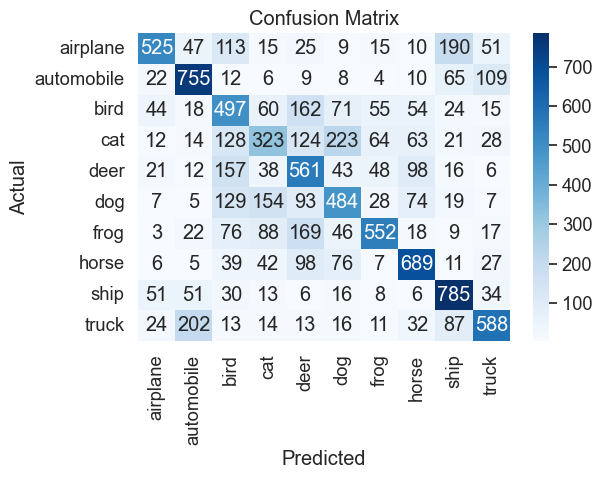

In [16]:
evaluate_cifar(model_quantized_test)

Итого, мы потеряли меньше одного процента в качестве и получили х4 сжатие. По-моему, здорово. Потенциально можно сжать еще сильнее, если использовать более компактные типы данных и меньшее число кластеров. Но в pytorch нет int4(

/Users/imoshkov/prog/.base/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inference | Elapsed time : 2.07
Accuracy: 0.5523
Precision: 0.581236673692298
Recall: 0.5523
F1-Score: 0.5575966359251538


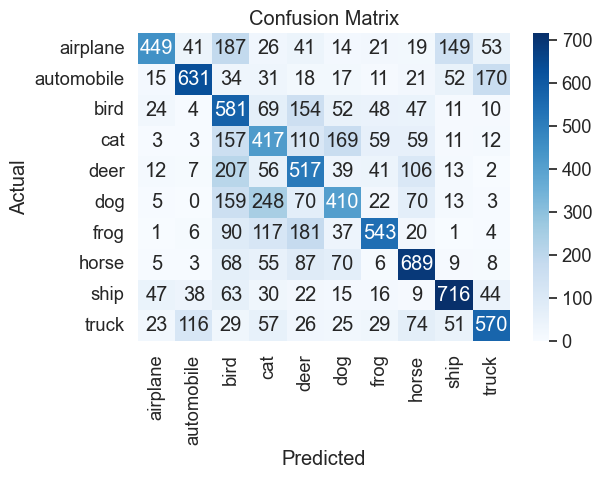

In [17]:
model_quantized_test = CompressibleLeNet(KMeans)
model_quantized_test.load_state_dict(net.state_dict())
model_quantized_test.save_compressed('compressed_lenet.pt', **dict(n_clusters=16, random_state=0))
model_quantized_test.load_compressed('compressed_lenet.pt')
evaluate_cifar(model_quantized_test)